In [1]:
import os
import sys
import json

import numpy as np
import pandas as pd

import xarray as xr
import geopandas
import rioxarray
from shapely.ops import unary_union

sys.path.append(os.path.join("../src"))
import process, correlation

import warnings
warnings.simplefilter("ignore")

### Variables

In [73]:
# Define time period for analysis
YEAR_START = 2015
YEAR_END = 2022

# Desired minimum number of models in ensemble
NUM_MODELS = 5

In [104]:
# List ssp scenarios to consider
ssps = [
    "ssp126",
    "ssp245",
    "ssp370",
    "ssp585"
    ]

# Specify scenario for plots
ssp_cur = "ssp585"

# Set varible to run comparison (choose one option)
# var = "temperature"
var = "precipitation"

### Some preparation

In [53]:
# Collect ensembles of the models in dictionary
ensembles = {
        "models_low_ECS": ["CAMS-CSM1-0",
                "INM-CM4-8",
                "MIROC6",
                "MPI-ESM1-2-HR",
                "NorESM2-MM"],

        "models_medium_ECS": ["AWI-CM-1-1-MR",
                "BCC-CSM2-MR",
                "CMCC-ESM2",
                "EC-Earth3",
                "GFDL-ESM4",
                "MRI-ESM2-0"],
                
        "models": ["ACCESS-CM2",
                "AWI-CM-1-1-MR",
                "BCC-CSM2-MR",
                "CanESM5",
                "CAMS-CSM1-0",
                "CMCC-ESM2",
                "CNRM-CM6-1",
                "EC-Earth3",
                "GFDL-ESM4",
                "INM-CM4-8",
                "IPSL-CM6A-LR",
                "MIROC6",
                "MPI-ESM1-2-HR",
                "MRI-ESM2-0",
                "NorESM2-MM",
                "UKESM1-0-LL"]
}

# Set the name of the ensemble to use
ens_name = "models"

In [54]:
# Coordinate bounds (limits Russia roughly)
LEFT = 20
RIGHT = 180
TOP = 82
BOTTOM = 41
bounds = (LEFT, RIGHT, TOP, BOTTOM)

In [74]:
# Years range
years = np.arange(YEAR_START,YEAR_END+1)

# Set main folders
path_data = '/rcp/data/'
path_data_processed = '/rcp/data_processed/'
path_results = "/rcp/results/"

# Create folders to process data
os.makedirs(os.path.join(path_results, "pics"), exist_ok = True)
os.makedirs(os.path.join(path_results, "csv"), exist_ok = True)
os.makedirs(path_data_processed + "yearly", exist_ok = True)
os.makedirs(os.path.join(path_data_processed ,
                        "{}_{}".format(years[0], years[-1])),
            exist_ok = True)
for ssp in ssps:
    os.makedirs(os.path.join(path_data_processed,
                            "yearly",
                            ssp),
                exist_ok = True)
    os.makedirs(os.path.join(path_data_processed,
                            "{}_{}".format(years[0], years[-1]),
                            ssp),
                exist_ok = True)

In [75]:
# Load country boundaries
gdf_country = geopandas.read_file(os.path.join(path_data, "boundary", "gadm41_RUS_0.json"))
gdf_country = gdf_country.rename(columns={"COUNTRY": "NAME_1"})

# The same on regional level
gdf = geopandas.read_file(os.path.join(path_data, "boundary", "gadm41_RUS_2.json"))
gdf.head()

gdf_region = pd.DataFrame(columns = ["NAME_1", "geometry"])
reg_names = pd.unique(gdf["NAME_1"])
for i, name in enumerate(reg_names):
    gdf_region.loc[i, "NAME_1"] = name
    gdf_region.loc[i, "geometry"] = unary_union(gdf[gdf["NAME_1"]==name]['geometry'])

,GID_2,GID_0,COUNTRY,GID_1,NAME_1,NL_NAME_1,NAME_2,VARNAME_2,NL_NAME_2,TYPE_2,ENGTYPE_2,CC_2,HASC_2,geometry
0,RUS.1.1_1,RUS,Russia,RUS.1_1,Adygey,РеспубликаАдыгея,Giaginskiyrayon,NA,Гиагинскийрайон,Raion,District,R43010,RU.AD.GI,"MULTIPOLYGON (((40.56050 44.89230, 40.50130 44..."
1,RUS.1.2_1,RUS,Russia,RUS.1_1,Adygey,РеспубликаАдыгея,Koshekhabl'skiyrayon,NA,Кошехабaльскийрайон,Raion,District,R43010,RU.AD.KO,"MULTIPOLYGON (((40.45650 44.75390, 40.47690 44..."
2,RUS.1.3_1,RUS,Russia,RUS.1_1,Adygey,РеспубликаАдыгея,Krasnogvardeyskiyrayon,NA,Красногвардейскийрайон,Raion,District,R43010,RU.AD.KR,"MULTIPOLYGON (((40.02920 45.06250, 40.01730 45..."
3,RUS.1.4_1,RUS,Russia,RUS.1_1,Adygey,РеспубликаАдыгея,Maykop,NA,Майкоп,Gorsovet,District,NA,RU.AD.MG,"MULTIPOLYGON (((40.13180 44.60050, 40.11040 44..."
4,RUS.1.5_1,RUS,Russia,RUS.1_1,Adygey,РеспубликаАдыгея,Maykopskiyrayon,NA,Майкопскийрайон,Raion,District,R43010,RU.AD.MR,"MULTIPOLYGON (((40.04870 44.77320, 40.07800 44..."


In [90]:
# Load dictionary with regions included in federal districts
with open(os.path.join(path_data, "districts", "districts_Anis.json"), 'r') as file:
    districts = json.load(file)

# Collect district boundaries by union those of corresponding regions
gdf_districts = pd.DataFrame(columns=['district', "geometry"])
gdf_districts.loc[0, "district"] = "РФ"
gdf_districts.loc[0, "geometry"] = gdf_country.loc[0, 'geometry']

for index, (district_name, district_regions) in enumerate(districts.items()):
    region_dict = districts[district_name]
    lines = pd.DataFrame(columns=gdf.columns)
    for name, areas in region_dict.items():
    # for record in region_list:
        if len(areas)==0:
            lines = pd.concat([lines, gdf.loc[gdf['NAME_1'].isin([name])]], axis=0)
        else:
            lines = pd.concat([lines, gdf.loc[gdf['NAME_1'].isin([name])& gdf['NAME_2'].isin(areas)]], axis=0)
    united_geom = unary_union(lines['geometry'])
    gdf_districts.loc[index+1, "district"] = district_name
    gdf_districts.loc[index+1, "geometry"] = united_geom

## Average data yearly

In [59]:
# Calculate yearly average of ERA data pixelwise
height, width = process.average_year_era(path_data,
                path_data_processed,
                var,
                years)

In [ ]:
# Calculate yearly average of CMIP data pixelwise for models ensemble
process.average_cmip_model(
    ensembles[ens_name],
    ssps,
    years,
    var,
    path_data,
    path_data_processed,
    height,
    width
)

In [63]:
# Average over CMIP ensemble
process.average_ensemble(
    ensembles,
    ens_name,
    ssps,
    var,
    path_data_processed,
    years)

## Average over few years

In [65]:
# Calculate ERA average over few years
process.average_era_years(
    var,
    path_data_processed,
    years)

In [67]:
# Calculate average of CMIP ensemble over few years
process.average_ensemble_years(
        ens_name,
        years,
        ssps,
        var,
        path_data_processed)

In [69]:
# Calculate average of single CMIP model over few years
process.average_cmip_years(
    ensembles,
    ens_name,
    years,
    ssps,
    var,
    path_data_processed)

## MAE of (CMIP - ERA) difference and its plot within borders

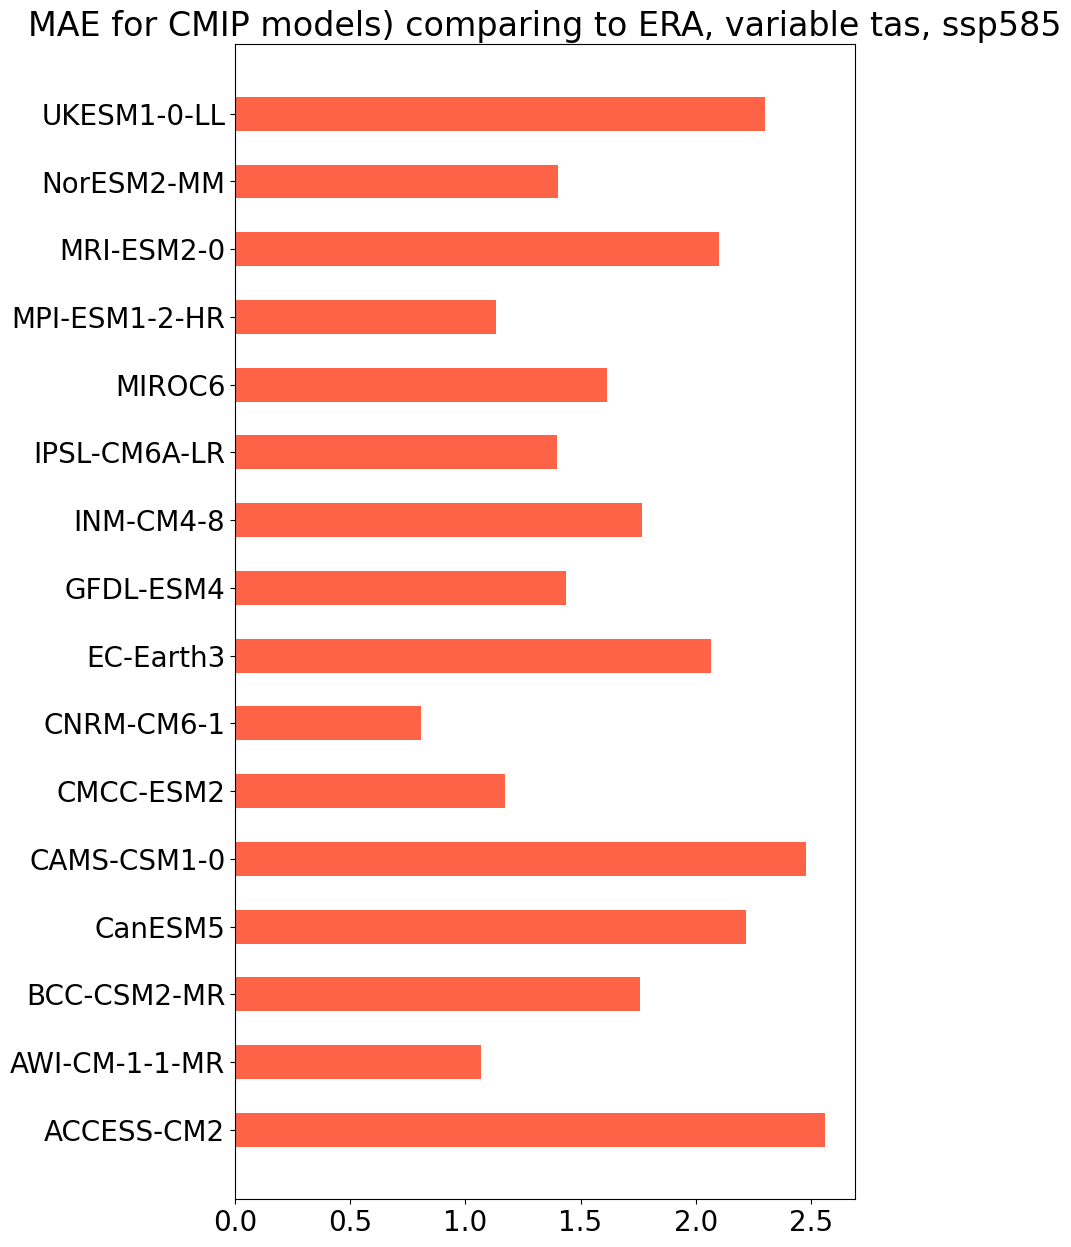

In [102]:
mae_scores_districts = correlation.calc_mae(
    ensembles,
    ens_name,
    ssp_cur,
    var,
    os.path.join(path_data_processed, "{}_{}".format(years[0], years[-1])),
    path_results,
    gdf_districts,
    should_plot = True
)
mae_scores_df = pd.DataFrame.from_dict(mae_scores_districts, orient='index').T
mae_scores_df.loc['mean'] = mae_scores_df.mean()
mae_scores_df.round(1)
mae_scores_df.to_csv(os.path.join(path_results, "csv", "mae_tas_district_{}.csv".format(ssp_cur)))

,РФ,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
ACCESS-CM2,67.0,69.0,44.0,78.0,48.0,149.0,76.0,101.0,51.0,58.0,113.0,53.0,47.0,80.0,73.0,88.0
AWI-CM-1-1-MR,122.0,83.0,101.0,119.0,51.0,143.0,84.0,132.0,93.0,136.0,147.0,108.0,128.0,153.0,189.0,85.0
BCC-CSM2-MR,82.0,92.0,85.0,37.0,37.0,132.0,75.0,59.0,36.0,83.0,110.0,66.0,80.0,111.0,103.0,209.0
CanESM5,87.0,78.0,65.0,161.0,69.0,167.0,142.0,127.0,47.0,80.0,106.0,67.0,67.0,114.0,109.0,108.0
CAMS-CSM1-0,112.0,176.0,202.0,152.0,152.0,176.0,164.0,136.0,114.0,196.0,116.0,88.0,58.0,92.0,110.0,70.0
CMCC-ESM2,68.0,68.0,46.0,31.0,20.0,123.0,60.0,40.0,70.0,141.0,99.0,57.0,41.0,76.0,79.0,120.0
CNRM-CM6-1,94.0,66.0,112.0,135.0,117.0,135.0,97.0,63.0,49.0,120.0,106.0,81.0,71.0,138.0,166.0,235.0
EC-Earth3,63.0,70.0,75.0,42.0,103.0,122.0,103.0,63.0,53.0,119.0,86.0,40.0,37.0,62.0,76.0,182.0
GFDL-ESM4,83.0,70.0,62.0,21.0,31.0,118.0,46.0,76.0,91.0,64.0,125.0,72.0,87.0,85.0,104.0,74.0
INM-CM4-8,95.0,73.0,37.0,37.0,90.0,121.0,43.0,72.0,53.0,83.0,140.0,85.0,99.0,99.0,184.0,397.0


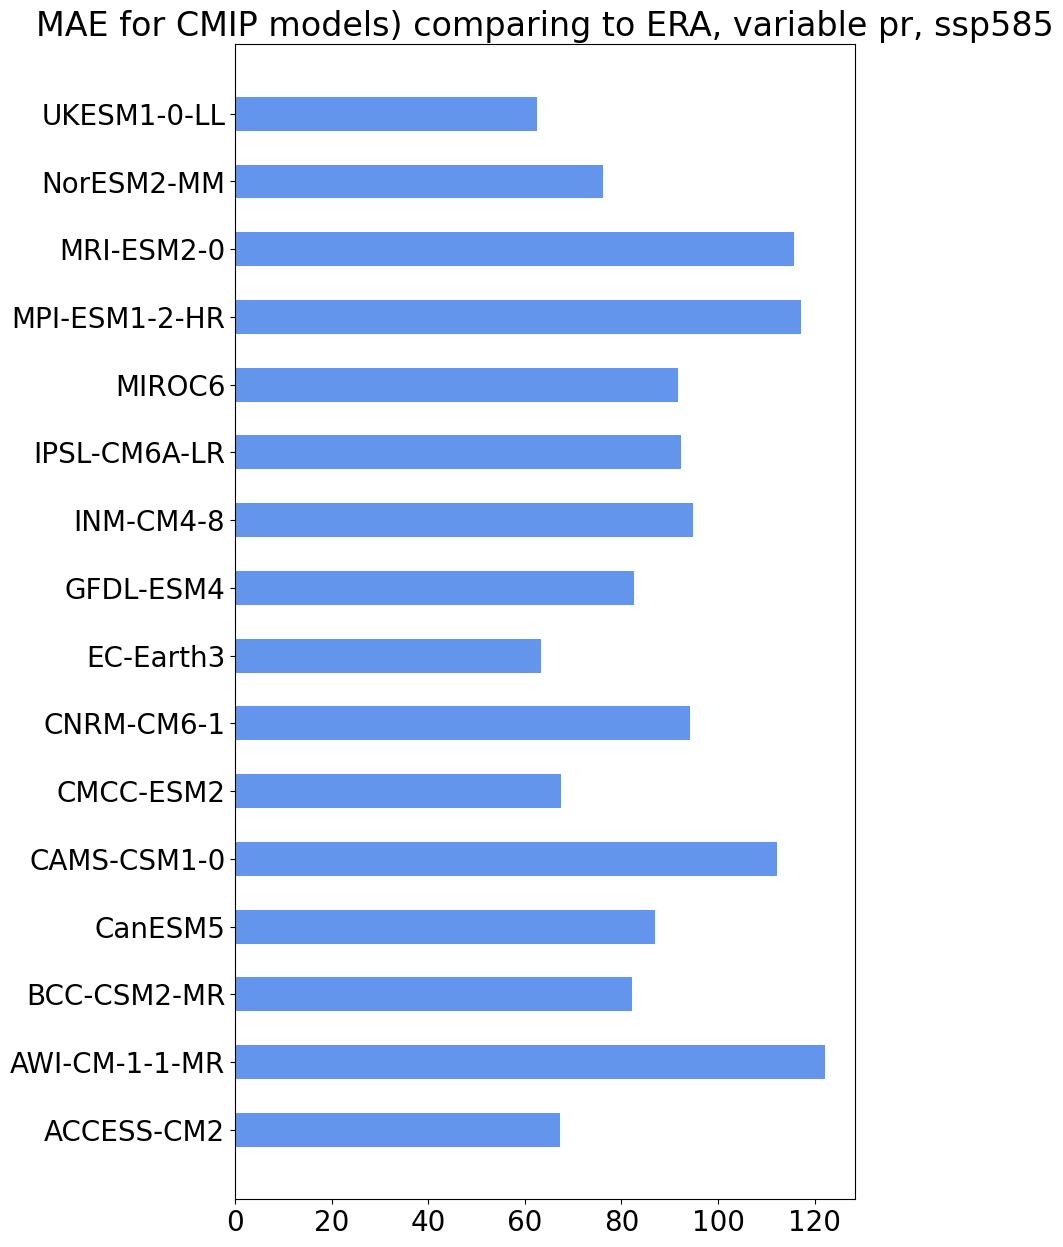

In [94]:
mae_scores_districts = correlation.calc_mae(
    ensembles,
    ens_name,
    ssp_cur,
    "precipitation",
    os.path.join(path_data_processed, "{}_{}".format(years[0], years[-1])),
    path_results,
    gdf_districts,
    should_plot = True
)
mae_scores_df = pd.DataFrame.from_dict(mae_scores_districts, orient='index').T
mae_scores_df.loc['mean'] = mae_scores_df.mean()
mae_scores_df.round(0)
mae_scores_df.to_csv(os.path.join(path_results, "csv", "mae_pr_district_{}.csv".format(ssp_cur)))

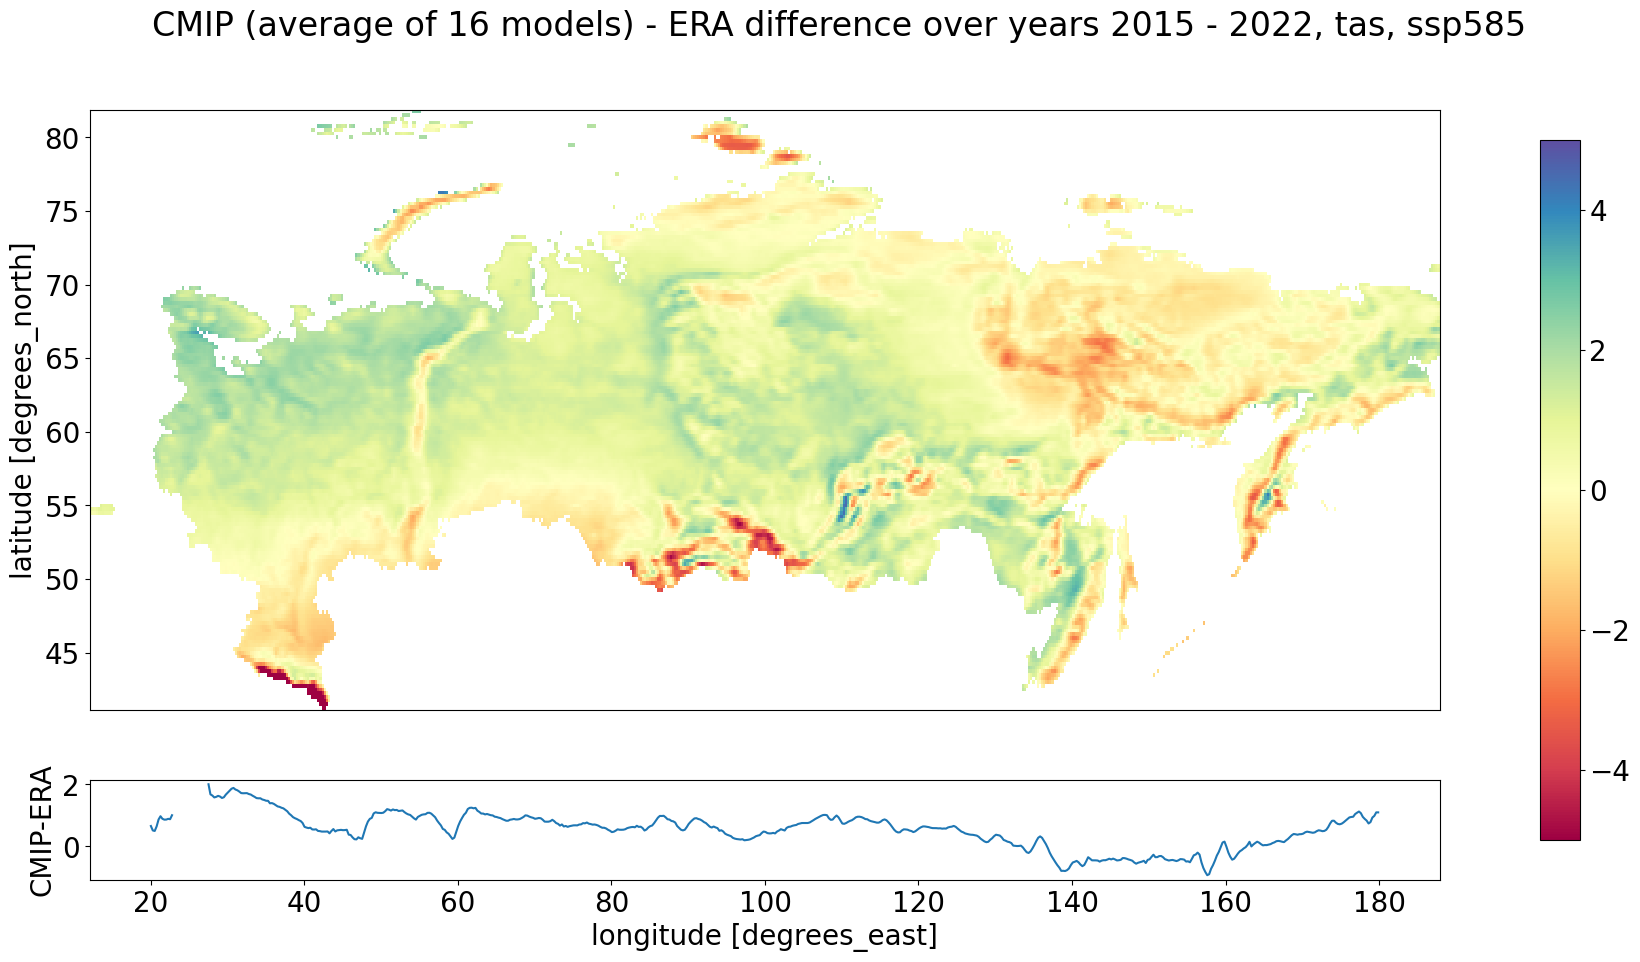

In [97]:
correlation.plot_difference(
                ensembles,
                ens_name,
                ssp_cur,
                years,
                "temperature",
                path_data_processed,
                path_results,
                gdf_country
)

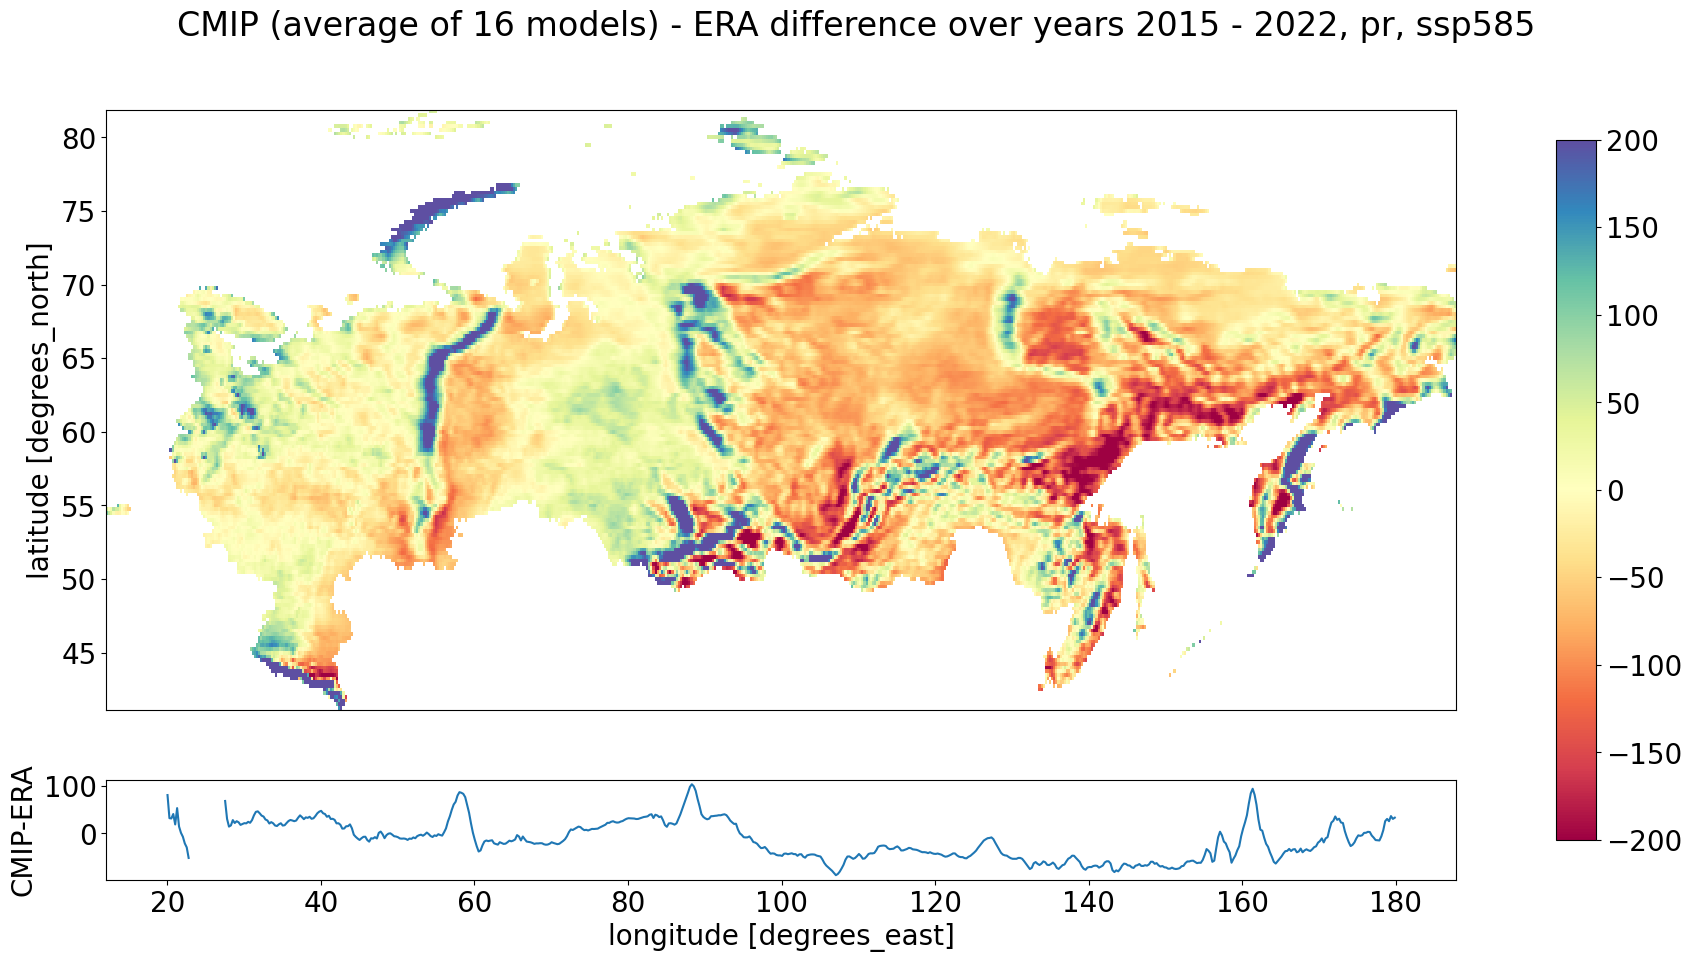

In [106]:
correlation.plot_difference(
                ensembles,
                ens_name,
                ssp_cur,
                years,
                "precipitation",
                path_data_processed,
                path_results,
                gdf_country
)

##  Districts analysis

In [122]:
import importlib
importlib.reload(correlation)

<module 'correlation' from '/Scenarios/notebook/../src/correlation.py'>

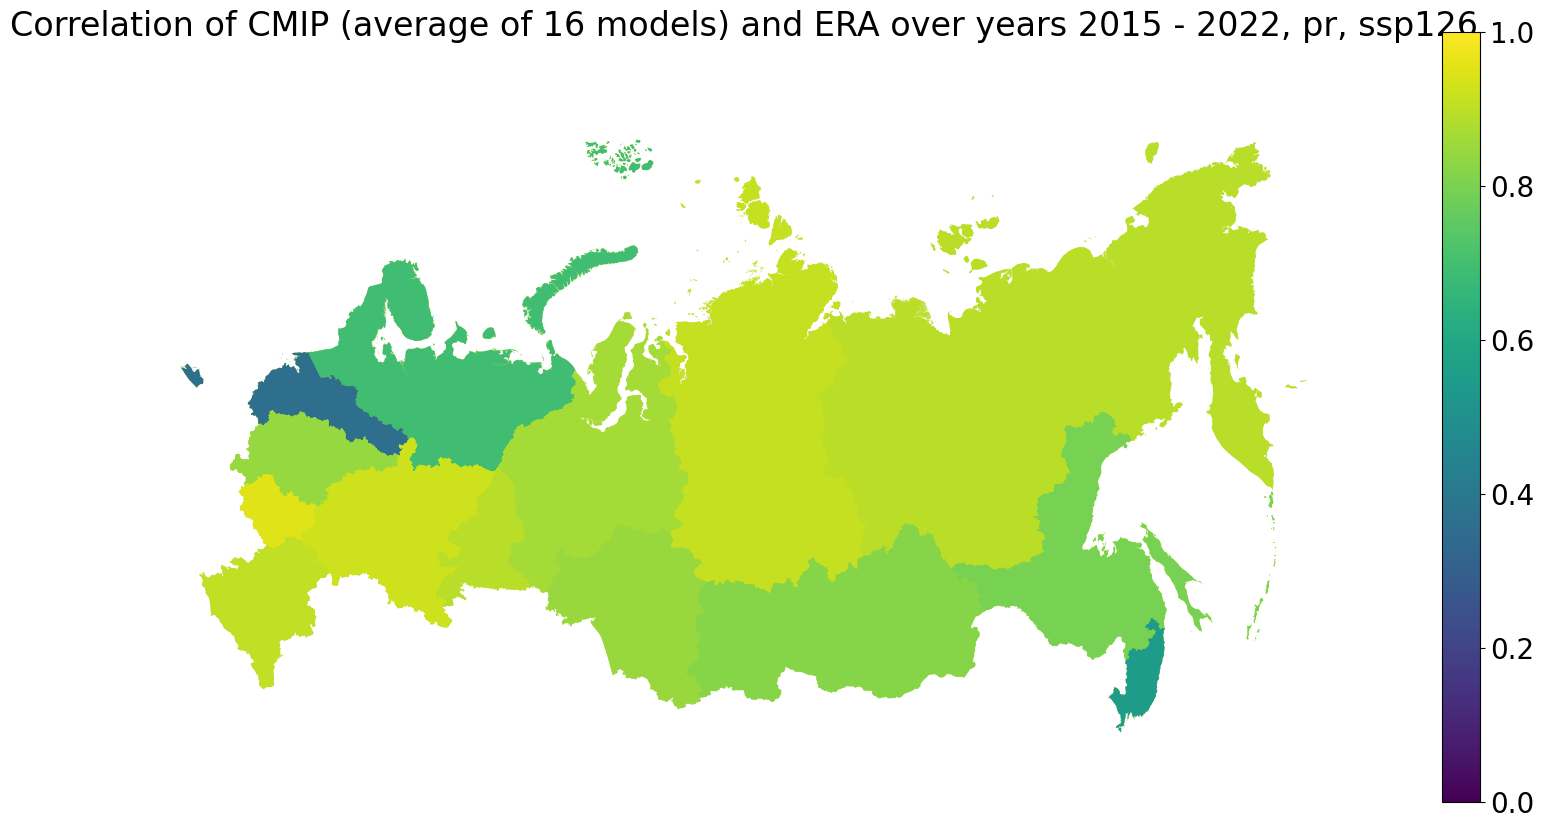

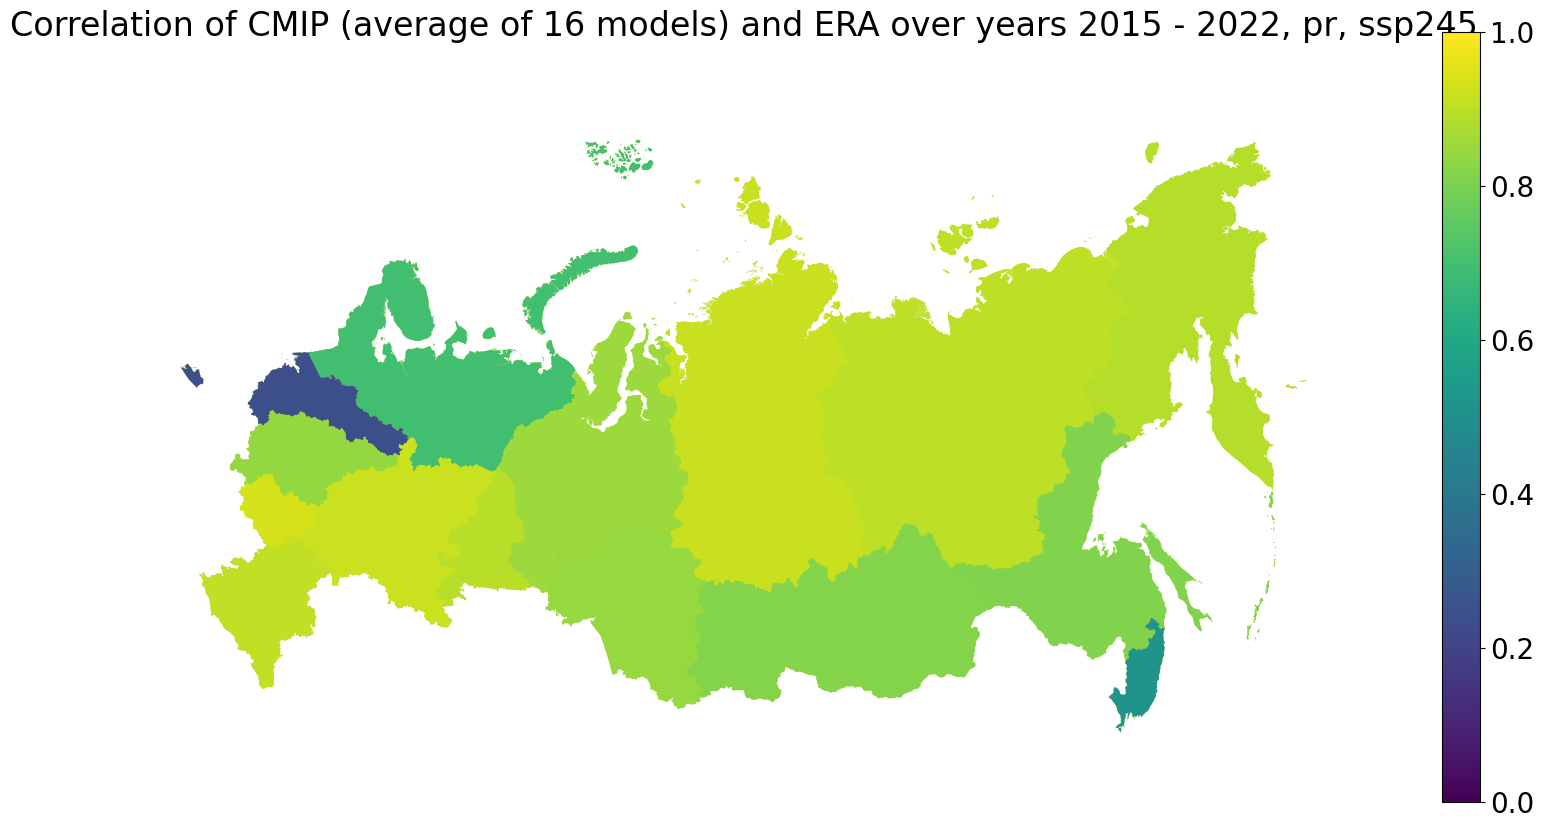

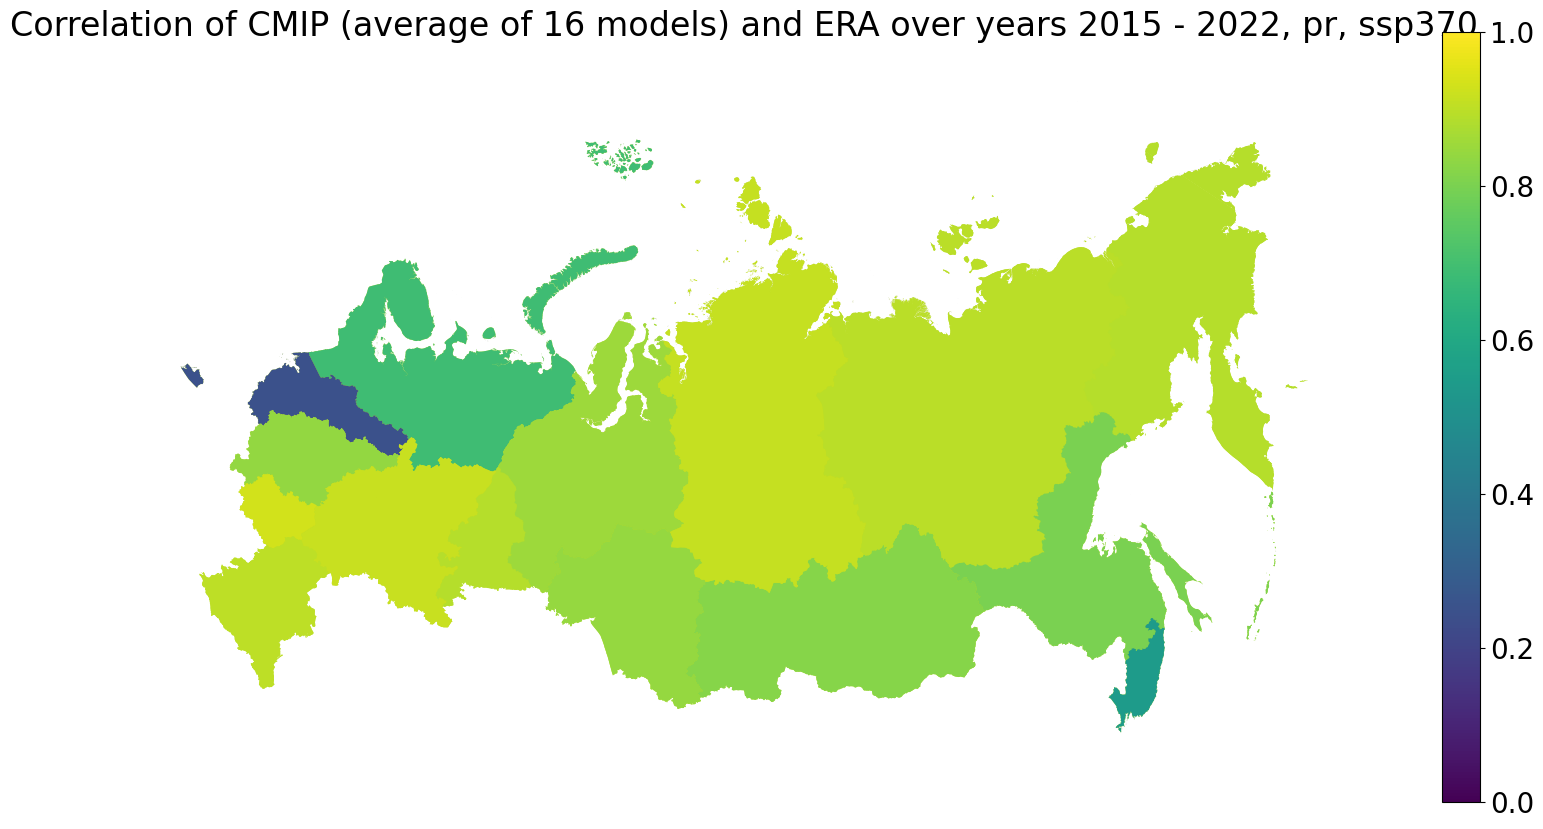

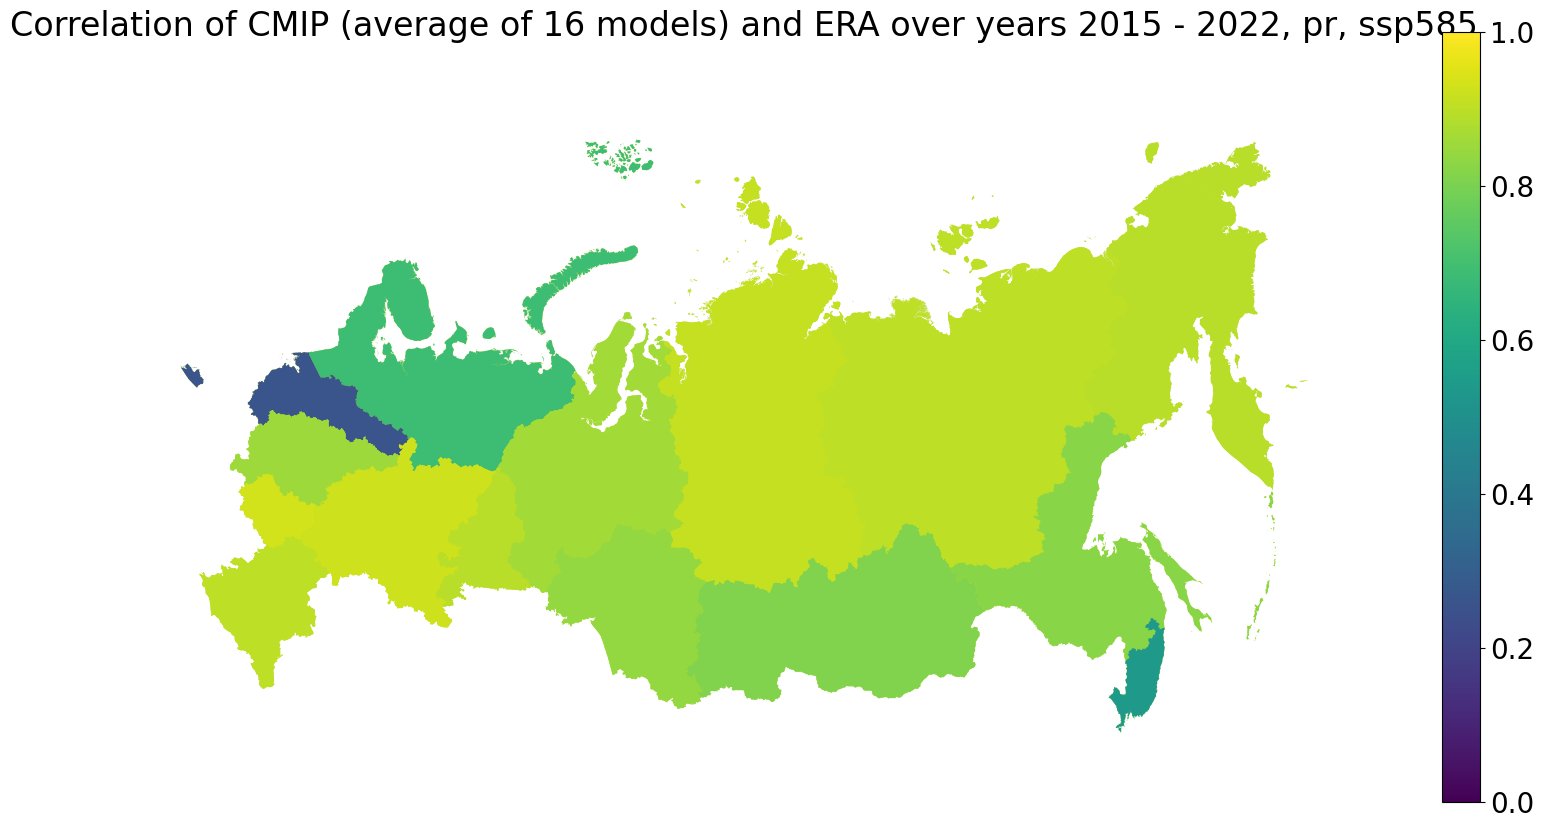

In [105]:
corr_districts = {}
corr_dict = correlation.plot_corr(
        ensembles[ens_name],
        ens_name,
        ssps,
        years,
        var,
        os.path.join(path_data_processed, "{}_{}".format(years[0], years[-1])),
        path_results,
        gdf_districts,
        corr_districts,
        "districts",
        districts
        )

## Regional analysis

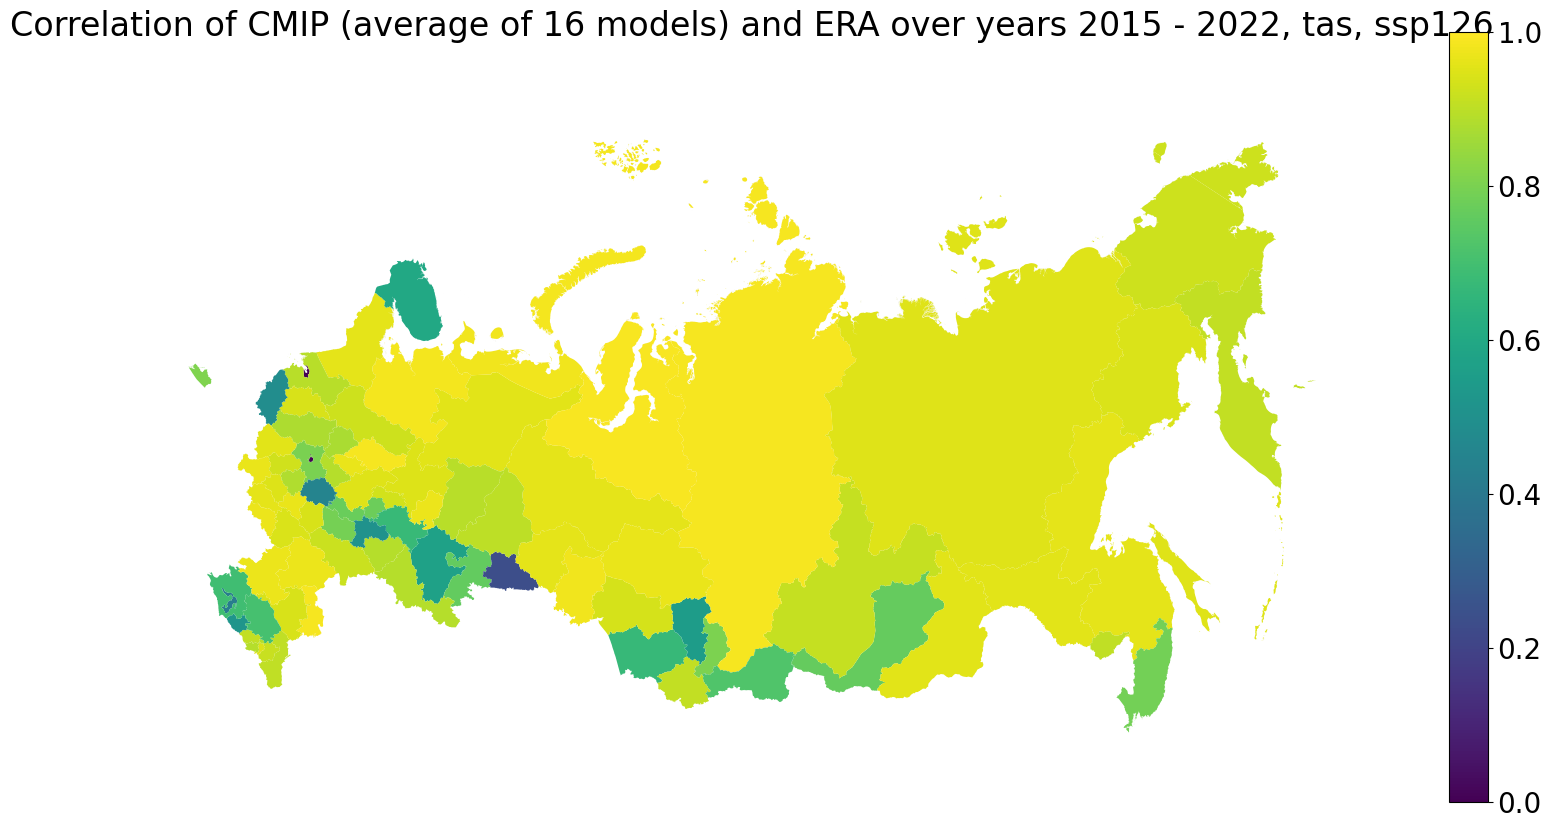

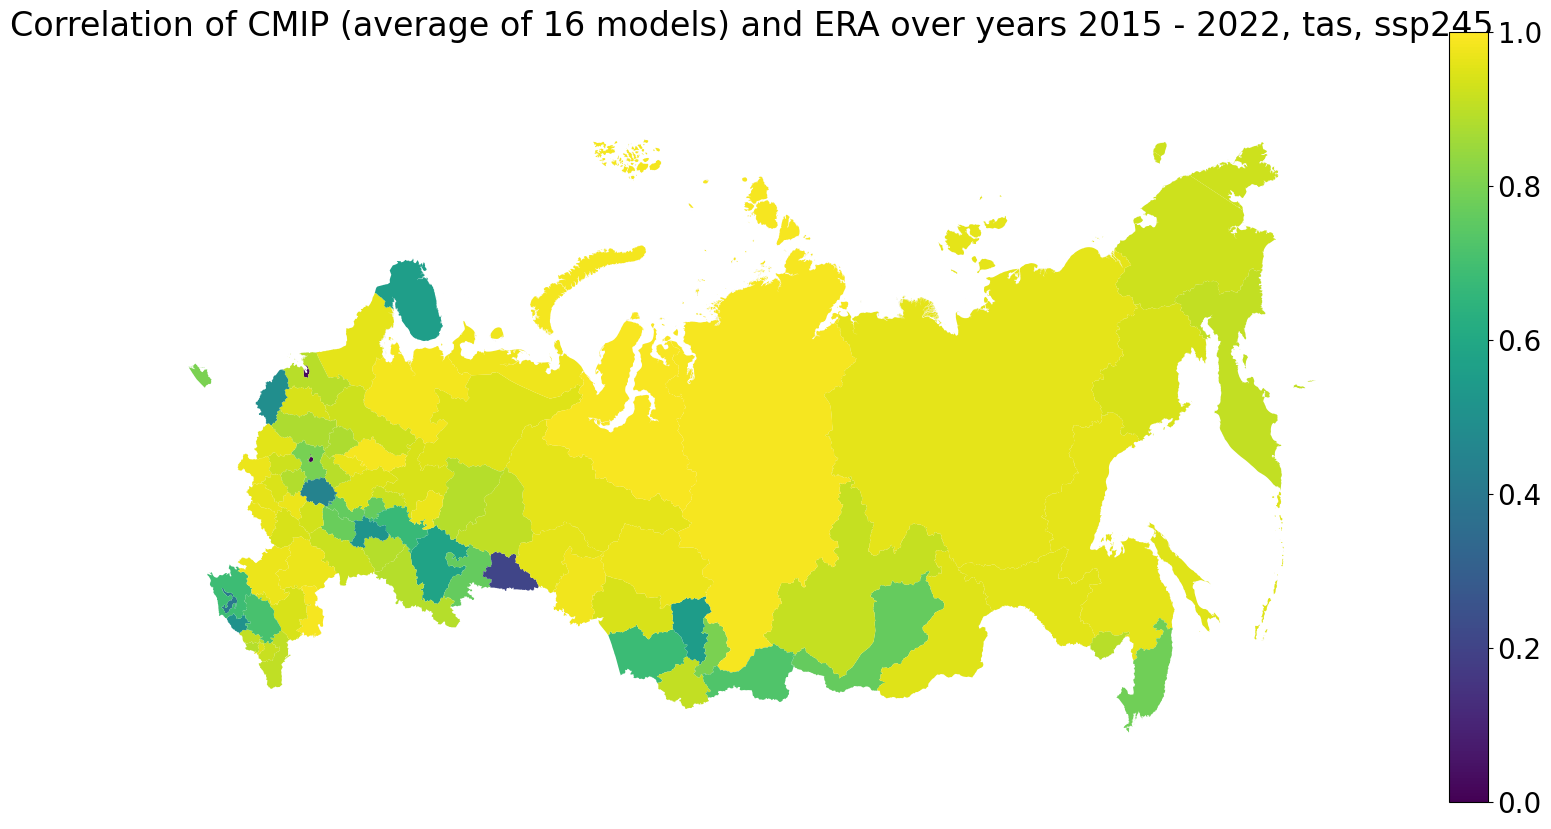

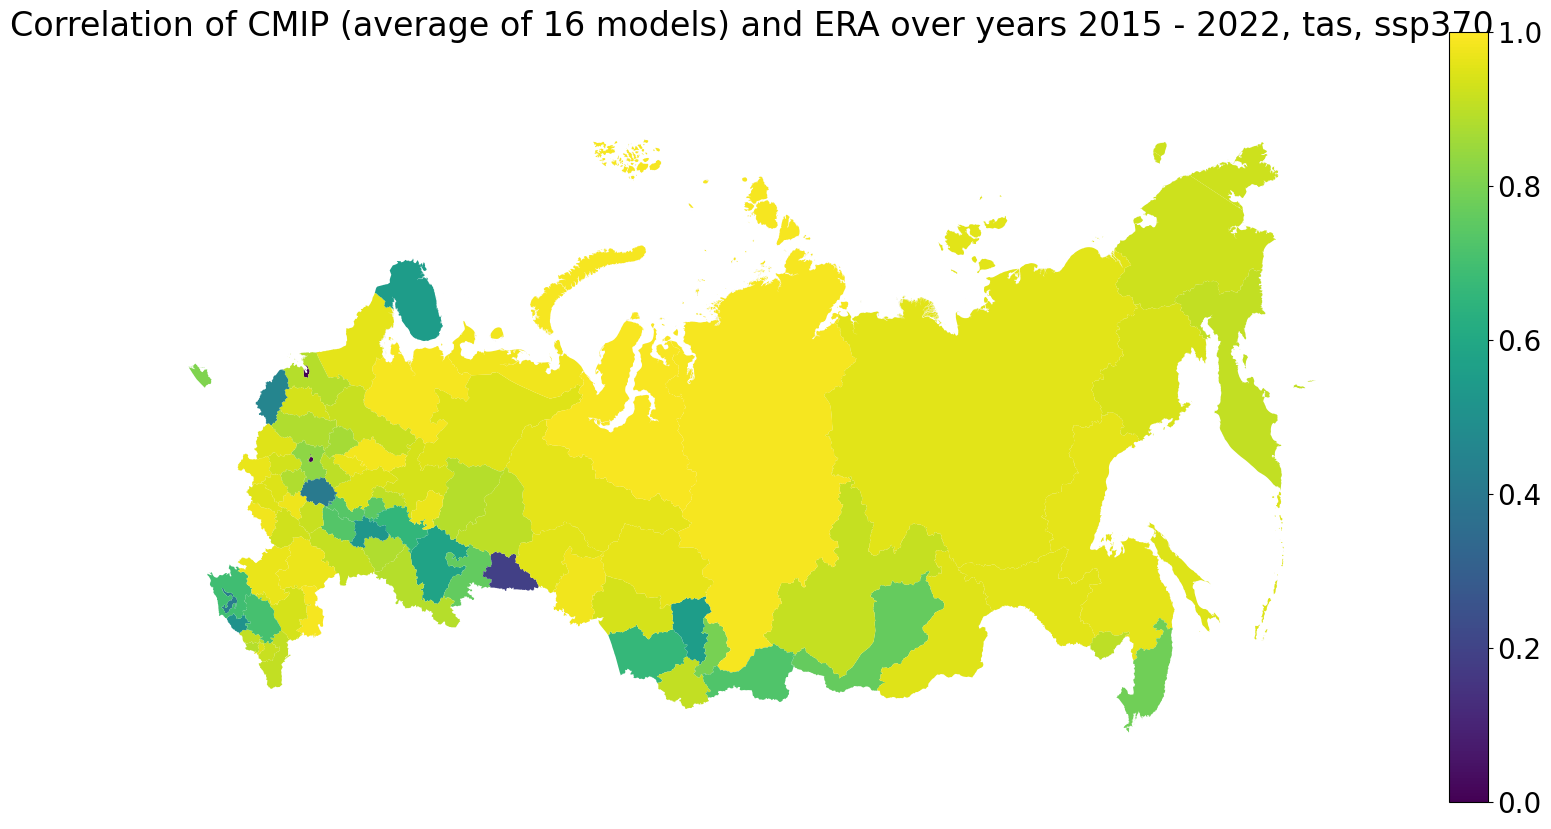

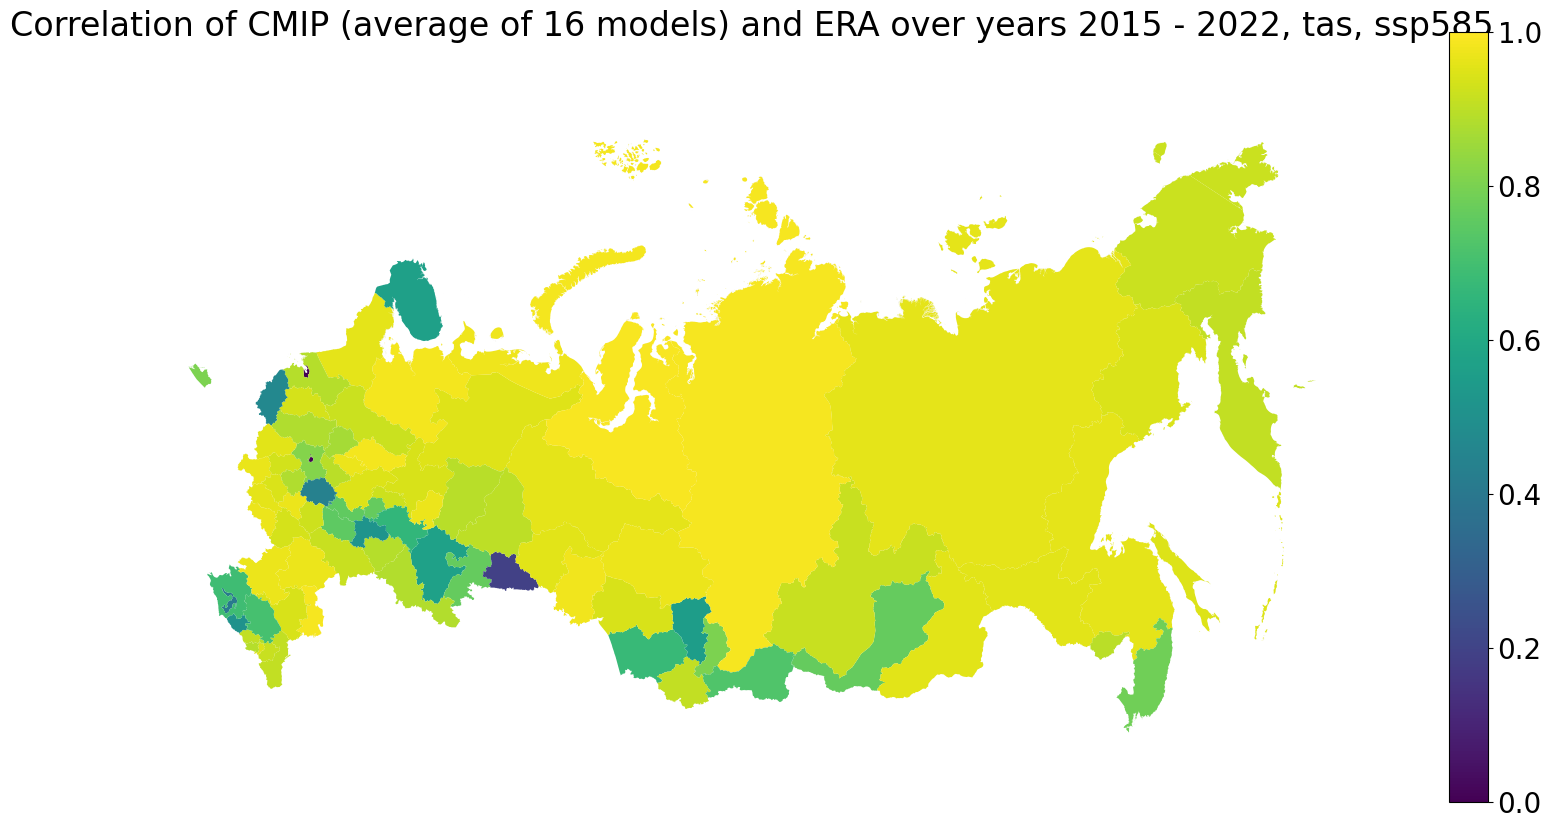

In [112]:
# Create dictionary to collect correlations
corr_regions = {}

corr_dict = correlation.plot_corr(
        ensembles[ens_name],
        ens_name,
        ssps,
        years,
        "temperature",
        path_data_processed,
        path_results,
        gdf_region,
        corr_regions,
        "regions"
        )

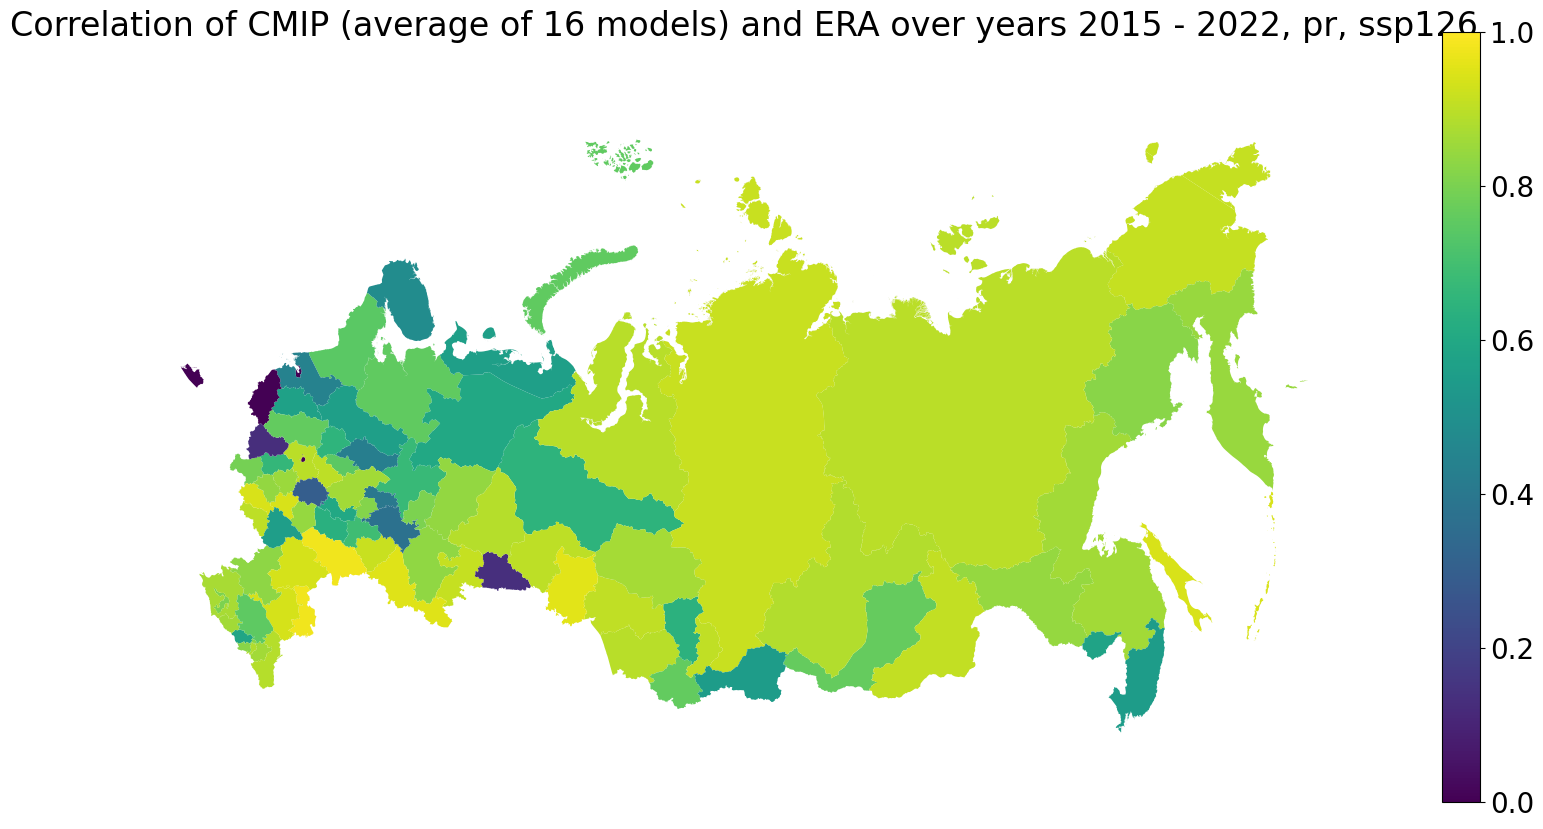

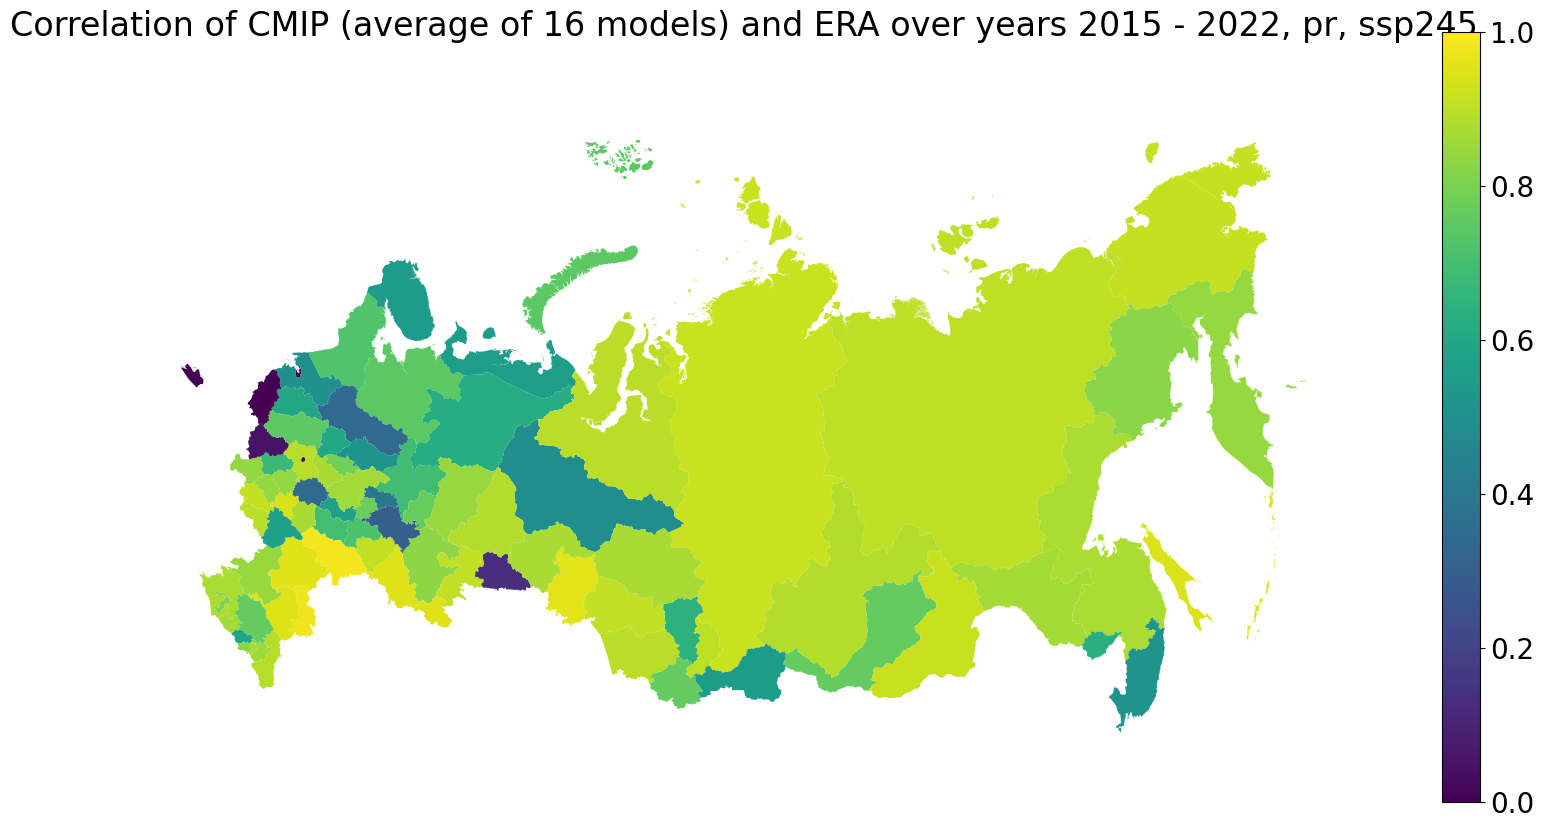

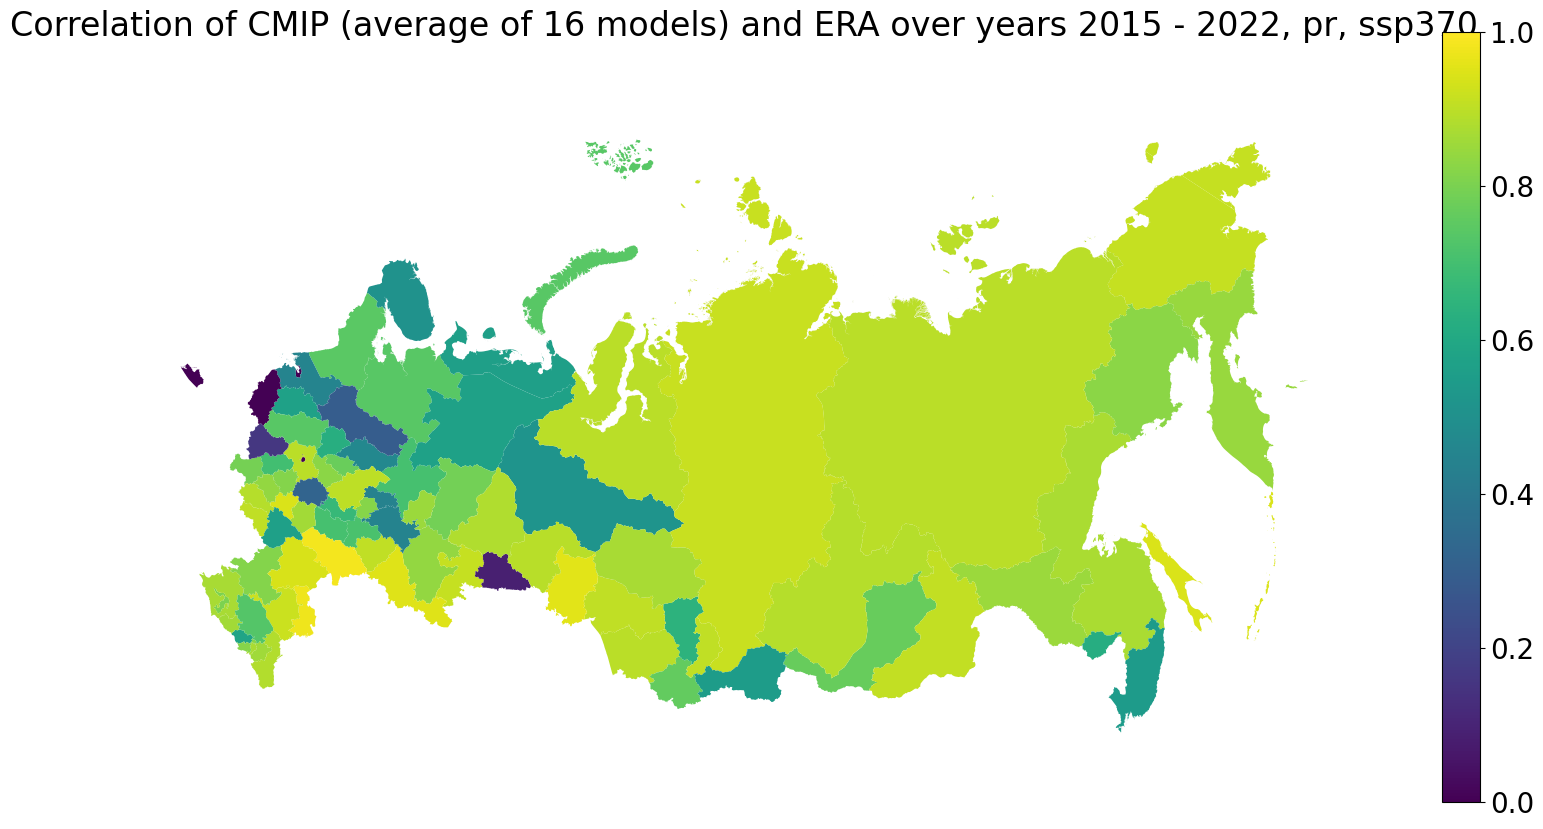

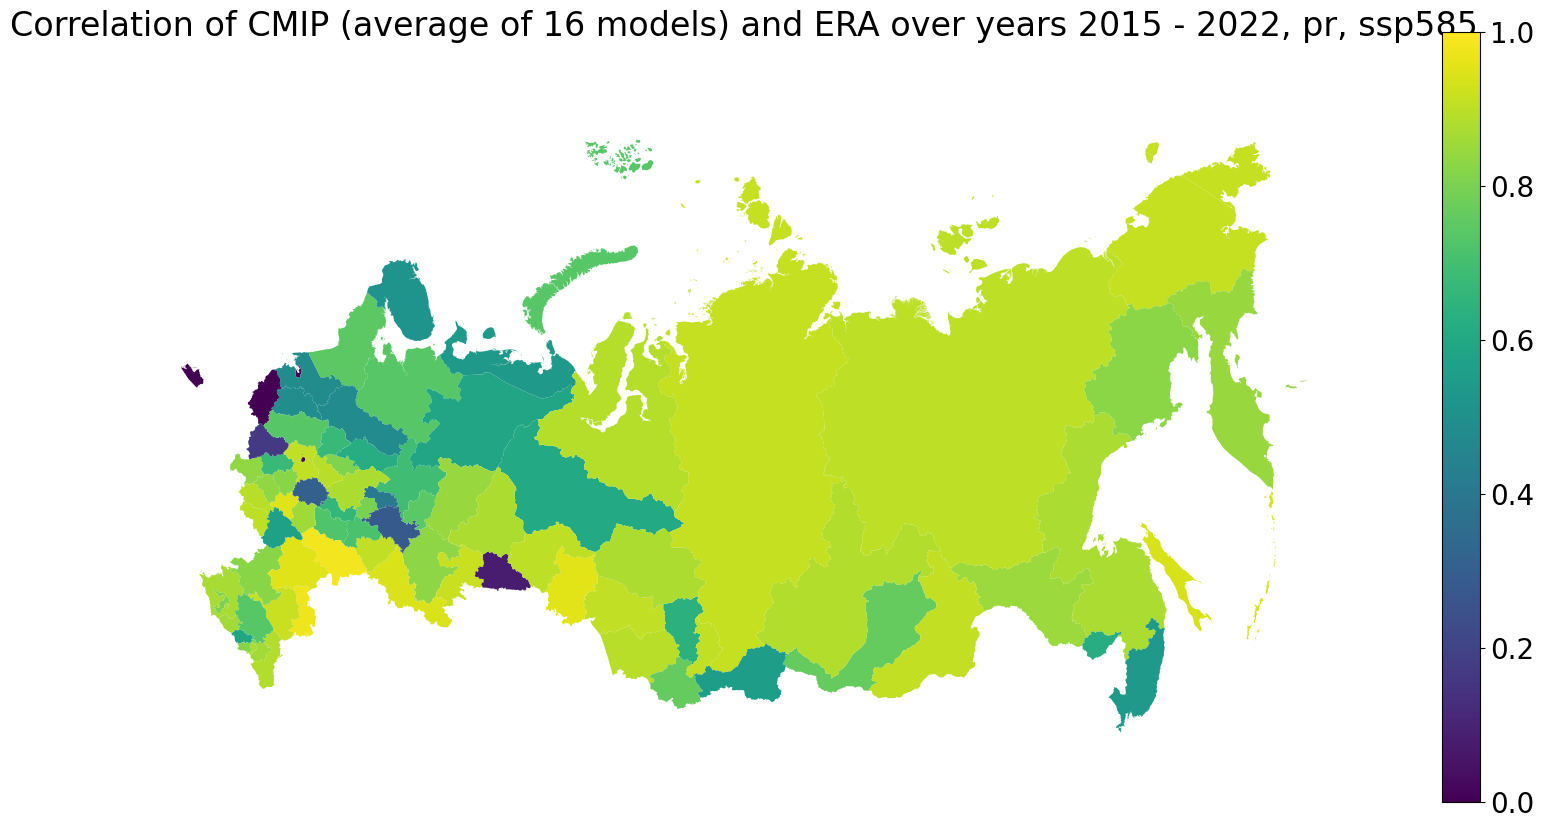

In [115]:
corr_dict = correlation.plot_corr(
        ensembles[ens_name],
        ens_name,
        ssps,
        years,
        "precipitation",
        path_data_processed,
        path_results,
        gdf_region1,
        corr_regions,
        "regions"
        )

In [116]:
# Take a closer look at correlations
corr = corr_regions["tas"]["ssp585"]
corr = corr[corr["NAME_1"].isin(["Chukot", "Yamal-Nenets", "Krasnoyarsk", "Sakha", "Magadan"])]
corr = corr.T.iloc[1:-2, :]
corr = corr.astype(float).round(2)
corr

,11,34,39,59,79
ACCESS-CM2,0.87,0.97,0.90,0.93,0.94
AWI-CM-1-1-MR,0.91,0.98,0.94,0.95,0.98
BCC-CSM2-MR,0.88,0.98,0.89,0.93,0.96
CanESM5,0.79,0.96,0.81,0.96,0.96
CAMS-CSM1-0,0.83,0.98,0.91,0.89,0.97
CMCC-ESM2,0.92,0.94,0.93,0.91,0.96
CNRM-CM6-1,0.89,0.99,0.94,0.95,0.98
EC-Earth3,0.94,0.93,0.90,0.77,0.94
GFDL-ESM4,0.91,0.99,0.94,0.91,0.98
INM-CM4-8,0.63,0.95,0.80,0.78,0.97


In [117]:
corr.describe()

,11,34,39,59,79
count,16.000000,16.000000,16.000000,16.000000,16.000000
mean,0.863125,0.968125,0.898125,0.883125,0.955000
std,0.074092,0.017595,0.046220,0.080888,0.043512
min,0.630000,0.930000,0.800000,0.670000,0.820000
25%,0.852500,0.960000,0.885000,0.872500,0.955000
50%,0.885000,0.975000,0.905000,0.910000,0.970000
75%,0.902500,0.980000,0.940000,0.930000,0.980000
max,0.940000,0.990000,0.940000,0.960000,0.990000


## Optimal models ensemble collection

In [123]:
best_models = correlation.optimal_ensemble(
                                        ensembles,
                                        ens_name,
                                        corr_regions,
                                        ssps,
                                        NUM_MODELS
)

# Save best models to .csv file
pd.DataFrame(best_models.items()).to_csv(os.path.join(path_results, "csv", "best_models.csv"))

Criterion 5 achieved for regions []
Criterion 4 achieved for regions []
Criterion 3 achieved for regions ['Belgorod', 'Chelyabinsk', 'Kostroma', 'Kurgan', 'Lipetsk', 'Tambov', "Tyumen'"]
Criterion 2 achieved for regions ['Adygey', 'Altay', 'Amur', "Astrakhan'", 'Bashkortostan', 'Bryansk', 'Buryat', 'Chukot', 'Chuvash', 'Ingush', 'Irkutsk', 'Ivanovo', 'Kabardin-Balkar', 'Kaliningrad', 'Kalmyk', 'Kaluga', 'Kamchatka', 'Karachay-Cherkess', 'Kemerovo', 'Khabarovsk', 'Khakass', 'Khanty-Mansiy', 'Kirov', 'Komi', 'Krasnoyarsk', 'Kursk', 'Leningrad', 'Mariy-El', 'Mordovia', 'MoscowCity', 'Moskva', 'Murmansk', 'Nenets', 'Nizhegorod', 'NorthOssetia', 'Novgorod', 'Novosibirsk', 'Orel', 'Orenburg', 'Penza', "Perm'", 'Pskov', 'Rostov', "Ryazan'", 'Sakha', 'Sakhalin', 'Samara', 'Saratov', 'Smolensk', 'Sverdlovsk', 'Tatarstan', 'Tomsk', 'Tula', "Tver'", 'Udmurt', "Ul'yanovsk", 'Vladimir', 'Volgograd', 'Vologda', 'Voronezh', 'Yamal-Nenets', "Yaroslavl'", 'Yevrey', "Zabaykal'ye"]
Criterion 1 achieved f